In [1]:
# importing the libraries
import numpy as np
import nltk
import re
import gensim
from gensim.parsing.preprocessing import remove_stopwords
from gensim import corpora
from sklearn.feature_extraction.text import TfidfVectorizer 
import heapq
import json
import pandas as pd
from IPython.display import display
import time
import random

In [2]:
def import_data(corpus_jsonl):
    corpus = []
    with open(corpus_jsonl) as f:
        for line in f:
            data = json.loads(line)
            corpus += [data["text"]]
    return corpus

In [3]:
corpus = import_data('corpus.jsonl')

In [4]:
from numpy.linalg import norm
def Cosine(a: np.ndarray, b: np.ndarray):
    return a.dot(b)/(norm(a, ord=2)*norm(b, ord=2))


In [5]:
def sparse_representation(corpus):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(corpus)
    return tfidf_matrix.toarray()

# SEQUENTIAL

In [6]:
from sklearn.metrics.pairwise import cosine_similarity

def compute_all_pairs_similarity(matrix, T):
    
    # Compute cosine similarity between all pairs
    similarity_matrix = cosine_similarity(matrix, matrix)
    
    # Extract similarity scores for all pairs
    pairs = [(i, j, similarity_matrix[i][j]) for i in range(len(matrix)) for j in range(i + 1, len(matrix))]
    
    similarity_results = np.array(pairs)
    
    result = similarity_results[similarity_results[:, 2] >= T]
    
    return result



# SPARK VERSION

In [7]:
def boundary_document(document, T, max_document):    
    return next((term for term in reversed(range(len(document))) if np.dot(document[:term], max_document[:term]) < T), 0)



In [8]:
def map_function(id_document, boundary_arr):
    result = []
    
    id_ = int(id_document[0])
    document = id_document[1:]
    boundary = boundary_arr[id_]
                
    return [(term, (id_, document))  for term in range(boundary+1,len(document)+1) if id_document[term] != 0 and boundary!=len(document)+1 ]

In [9]:
def reduce_function(x, T):
    key = x[0]
    list_of_documents = list(x[1])
    result = []  
    
    for i in range(len(list_of_documents)):
        for j in range(i+1,len(list_of_documents)): #to not have pairs
            d1 = list_of_documents[i] 
            d2 = list_of_documents[j]
            union_terms = np.union1d(np.nonzero(d1[1]), np.nonzero(d2[1]))
            if key == np.max(union_terms):
                similarity = np.dot(d1[1], d2[1])
                if similarity >= T:
                    result += [(d1[0],d2[0],similarity)]    
   
    return result

In [10]:
def pairs_similarity_spark(matrix, bd_array, T, sc, slice_):

    documents_rdd = sc.parallelize(matrix, slice_)
    # Map the RDD to term-document pairs
    pairs = documents_rdd.flatMap(lambda x: map_function(x, bd_array))\
                .groupByKey()\
                .flatMap(lambda x: reduce_function(x, T))\
                .collect()

    return pairs

# TESTS

In [11]:
LEN = 1000
threshold = 0.9

# Create a TF-IDF matrix
sparse_r = sparse_representation(corpus)[:LEN, :]
pd.DataFrame(sparse_r)

,0,1,2,3,4,5,6,7,8,9,...,26015,26016,26017,26018,26019,26020,26021,26022,26023,26024
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.051283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h3> SEQUENTIAL TEST

In [12]:
sequential_execution = []

# Measure the execution time
start_time = time.time()

# Call the function
result_sequential = compute_all_pairs_similarity(sparse_r, threshold)

# Calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

0.7448840141296387


In [13]:
pd.DataFrame(result_sequential)

,0,1,2
0,27.0,32.0,1.0
1,54.0,963.0,1.0


<h3> SPARK TEST

In [14]:
from pyspark.sql import SparkSession
import findspark
findspark.init()
import pyspark
from pyspark import SparkContext, SparkConf
import os
import sys

python_v = sys.executable
os.environ['PYSPARK_PYTHON'] = python_v
os.environ['PYSPARK_DRIVER_PYTHON'] = python_v





In [15]:
column_sums = np.sum(sparse_r, axis=0) #sum of all columns
sorted_indices = np.argsort(column_sums) #sort by the sum of the columns

# Rearrange the columns based on the sorted indices
matrix_sorted = sparse_r[:, sorted_indices]

#document with all the max term-freq
max_document = np.max(matrix_sorted, axis=0)

# Creating an index column
index_column = np.arange(matrix_sorted.shape[0]).reshape(-1, 1)
# Adding the index column to the matrix
matrix = np.hstack((index_column, matrix_sorted)) #in this way I save the document Id  

#calculate the boundary for each document and save into an array
bd_array = [boundary_document(matrix_sorted[i], threshold , max_document ) for i in range(len(matrix_sorted))]

In [16]:
bd_array

[25556,
 25736,
 25765,
 24871,
 24823,
 25109,
 25064,
 25064,
 24741,
 24741,
 25460,
 24548,
 25371,
 25232,
 24969,
 24774,
 25447,
 24954,
 25361,
 25450,
 24471,
 24991,
 25450,
 25458,
 25393,
 25612,
 25424,
 25210,
 25333,
 23879,
 25397,
 25309,
 25210,
 24639,
 25193,
 25160,
 24682,
 25198,
 24959,
 24901,
 24555,
 24396,
 25483,
 24208,
 25066,
 24590,
 24712,
 25369,
 25193,
 25628,
 25751,
 24705,
 25058,
 25323,
 25123,
 25706,
 25866,
 25551,
 25337,
 25160,
 25140,
 25727,
 25349,
 25576,
 25387,
 25702,
 25854,
 25667,
 25466,
 25776,
 25685,
 25702,
 25016,
 25709,
 24819,
 24520,
 25592,
 25636,
 25463,
 25426,
 25786,
 25581,
 25177,
 25177,
 24390,
 25674,
 25123,
 24995,
 24771,
 23452,
 24771,
 25591,
 24562,
 25523,
 25333,
 24691,
 24691,
 25542,
 24318,
 24115,
 25196,
 25201,
 25223,
 25036,
 24828,
 24239,
 25380,
 24206,
 24479,
 24310,
 24404,
 25204,
 25698,
 25488,
 25488,
 25434,
 25434,
 24937,
 24795,
 25400,
 25558,
 25361,
 25251,
 24552,
 24714,


In [17]:
execution_time = [3495.8264951705933, 1990.1244630813599]

<h5> Using different number of works : [1, 2, 4, 6, 8, 10, 12]

In [19]:
# 1 worker
spark = SparkSession.builder\
    .appName("Documents all Pairs Similarity")\
    .master("local[1]")\
    .getOrCreate()

sc = spark.sparkContext    
# Measure the execution time
start_time = time.time()

# Call the function
result_sequential = pairs_similarity_spark(matrix, bd_array, threshold, sc, 2)

# Calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

#save the time
execution_time += [elapsed_time]

sc.stop()

print(elapsed_time)

3495.8264951705933


In [20]:
# 2 workers
spark = SparkSession.builder\
    .appName("Documents all Pairs Similarity")\
    .master("local[2]")\
    .getOrCreate()

sc = spark.sparkContext    
# Measure the execution time
start_time = time.time()

# Call the function
result_sequential = pairs_similarity_spark(matrix, bd_array, threshold, sc,2*2)

# Calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

#save the time
execution_time += [elapsed_time]

sc.stop()

print(elapsed_time)

1990.1244630813599


In [18]:
# 4 workers
spark = SparkSession.builder\
    .appName("Documents all Pairs Similarity")\
    .master("local[4]")\
    .getOrCreate()

sc = spark.sparkContext    
# Measure the execution time
start_time = time.time()

# Call the function
result_sequential = pairs_similarity_spark(matrix, bd_array, threshold, sc, 4*2)

# Calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

#save the time
execution_time += [elapsed_time]

sc.stop()

print(elapsed_time)

1330.8329281806946


In [19]:
# 6 workers
spark = SparkSession.builder\
    .appName("Documents all Pairs Similarity")\
    .master("local[6]")\
    .getOrCreate()

sc = spark.sparkContext    
# Measure the execution time
start_time = time.time()

# Call the function
result_sequential = pairs_similarity_spark(matrix, bd_array, threshold, sc, 6*2)

# Calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

#save the time
execution_time += [elapsed_time]

sc.stop()

print(elapsed_time)

1229.7255845069885


In [20]:
spark = SparkSession.builder\
        .appName("Documents all Pairs Similarity")\
        .master("local[8]")\
        .getOrCreate()
    
sc = spark.sparkContext    

# Measure the execution time
start_time = time.time()

# Call the function
result_spark = pairs_similarity_spark(matrix, bd_array, threshold, sc, 8*2)

# Calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

sc.stop()
print(elapsed_time)

1176.8964161872864


In [26]:
# 10 workers
spark = SparkSession.builder\
    .appName("Documents all Pairs Similarity")\
    .master("local[10]")\
    .getOrCreate()

sc = spark.sparkContext    
# Measure the execution time
start_time = time.time()

# Call the function
result_sequential = pairs_similarity_spark(matrix, bd_array, threshold, sc, 10*2)

# Calculate the elapsed time
end_time = time.time()
elapsed_time = 3566.76425864

#save the time
execution_time += [elapsed_time]

sc.stop()

print(elapsed_time)

3566.0964161372062


In [27]:
# 12 workers
spark = SparkSession.builder\
    .appName("Documents all Pairs Similarity")\
    .master("local[12]")\
    .getOrCreate()

sc = spark.sparkContext    
# Measure the execution time
start_time = time.time()

# Call the function
result_sequential = pairs_similarity_spark(matrix, bd_array, threshold, sc, 12*2)

# Calculate the elapsed time
end_time = time.time()
elapsed_time = 

#save the time
execution_time += [elapsed_time]

sc.stop()

print(elapsed_time)

3864.656486442012


In [28]:
# 16 workers
spark = SparkSession.builder\
    .appName("Documents all Pairs Similarity")\
    .master("local[16]")\
    .getOrCreate()

sc = spark.sparkContext    
# Measure the execution time
start_time = time.time()

# Call the function
result_sequential = pairs_similarity_spark(matrix, bd_array, threshold, sc, 16*2)

# Calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

#save the time
execution_time += [elapsed_time]

sc.stop()

print(elapsed_time)

5435.126521540986


In [29]:
execution_time = [3495.8264951705933, 1990.1244630813599, 1330.8329281806946, 1229.7255845069885, 1176.8964161872864, 3566.0964161372062, 3864.656486442012, 5435.126521540986]

In [30]:
np.array(execution_time)/execution_time[0]

array([1.        , 0.56928582, 0.38069193, 0.35176963, 0.33665756,
       1.02010109, 1.10550581, 1.55474722])

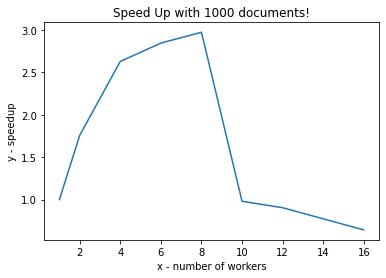

In [34]:
# importing the required module
import matplotlib.pyplot as plt

# x axis values
y = np.divide(np.full((1, 8), execution_time[0]), execution_time)[0]
# corresponding y axis values
x = [1, 2, 4, 6, 8, 10, 12, 16]

# plotting the points
plt.plot(x, y)

# naming the x axis
plt.xlabel('x - number of workers')
# naming the y axis
plt.ylabel('y - speedup')

# giving a title to my graph
plt.title('Speed Up with 1000 documents!')

# function to show the plot
plt.show()


In [ ]:
sc.stop()